In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import scipy
# import scipy.signal
plt.rcParams['agg.path.chunksize'] = 10000

In [2]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = (10**6) * pc

In [3]:
def htilde(f,eps,params):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    
    # Load the parameters
    Mchirp_true = M_sun * np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    Deff = params[3]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    # PN expansion parameter (velocity).
    
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units of seconds. This is a Continuous 
    # Time Fourier representation of the signal in the time domain.
    
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756 + (55/9)*eta_true)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta_true*v**(-2)
    
    psi2PN = (15293365/508032+(27145/504)*eta_true+(3085/72)*eta_true**2)*v**(-1)
    psi25PNlog = pi*(38645/252- (65/3) *eta_true)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 - (640/3) * (pi**2) -6848/21 *np.euler_gamma
              + eta_true*(-15335597827/3048192 + (2255/12) * (pi**2) - 1760/3 * theta - 12320/9 * delta)
              + (eta_true**2) *76055/1728 - (eta_true**3) * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + (378515./1512) *eta_true - 74045./756 * (eta_true**2)* (1-eps))
    psi_fullPN = (3/(128*eta_true))*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    return amplitude* np.exp(-1j*psi)


def T_chirp(fmin,M_chirp,eta):
    """
    Calculate time elapsed until merger.
    
    """

    M = (m1 + m2)*M_sun
    M_chirp *= M_sun
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

def final_frequency(M_chirp,eta):
    """
    Schwarzschild ISCO
    """
    M_tot = M_chirp*eta**(-3/5) * M_sun
    
    return (c**3)/(6*np.sqrt(6)*np.pi*G*M_tot)
    


In [4]:

def inner_prod(sig1_f,sig2_f,PSD,delta_f):
    """
    Inner Product with known PSD. Here we use Parseval's theorem. Note the definition of the SNR.
    """
    return (4*delta_f)  * np.real(sum(sig1_f*np.conjugate(sig2_f)/PSD))

def window_zero_pad(waveform,N_t):
    """
    There is a bias when alpha \neq 0. Need to fix this. 
    """
    taper = scipy.signal.tukey(len(waveform),0)
    waveform *= taper
    waveform_w_pad = np.pad(waveform, (0, N_t - len(waveform)), 'constant', constant_values=(0))
    
    return waveform_w_pad

def PowerSpectralDensity(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. This version of the PSD includes
    the sky-averaging position 'penalty', which takes into account the fact that, for some
    LISA sources, the wavelength of the GWs is shorter than LISA's arms.
    
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**-3    
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))  
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    Sc = 0  
    PSD = ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD
        
    where_are_NaNs = np.isnan(PSD) #In case there are nans,
    PSD[where_are_NaNs] = 1e100    #set the PSD value for them to something very high and let's be done with it.
    
    return PSD

In [5]:
"""
Signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =1.
phi0 =0.
fmin = 1e-4

# variables to sample through

#logDeff_true = np.log(10**2 *Mpc)

Deff_1 = 5 * 1e3 * Mpc
beta_1 = 6
m1 = 1e6  
m2 = 5*1e6
M_tot_1 = (m1 + m2)  # M_tot in kilograms
eta_1 = (m1*m2)/(M_tot_1**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_1 = M_tot_1*eta_1**(3/5)  # Chirp mass in units of kilograms 


f_max = final_frequency(M_chirp_1,eta_1)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max = T_chirp(fmin,M_chirp_1,eta_1)     # Calculate maximum chirping time that binary radiates stuff

logMchirp_1 = np.log(M_chirp_1)


pars_1 = [logMchirp_1,eta_1,beta_1,Deff_1] # array of parameters for waveform.

# Waveform Errors. True waveform has eps = 0. Approximate waveform has eps_AP \neq 0. Set 
# eps_AP = eps_GR if you do not care about waveform errors.

eps_GR = 0
eps_AP = (4*1*1e-2)

delta_t = 1/(2*f_max)         # Set sampling interval so that we can resolved frequencies signals

t = np.arange(0,t_max,delta_t)     # Set up useless time vector
n_t = len(t)                       # Extract length of supposed signal in the time domain

delta_f = 1/(n_t*delta_t)          # Extract sampling frequency

freq_bin = np.arange(fmin,f_max,delta_f)     # Extract frequency series
n_f = len(freq_bin)                          # Extract length of frequency domain series

h_f_1 = htilde(freq_bin,eps_GR,pars_1)       # True signal

PSD = PowerSpectralDensity(freq_bin)  # Extract PSD

SNR2_1 = inner_prod(h_f_1,h_f_1,PSD,delta_f)

print('SNR for source 1',np.sqrt(SNR2_1))


SNR for source 1 1405.6625088568965


In [6]:
# Numerical Derivatives - Source 1

# LogMchirp

logMchirp_delta = 1e-6
params_1_p = [logMchirp_1 + logMchirp_delta,eta_1,beta_1,Deff_1]
params_1_m = [logMchirp_1 - logMchirp_delta,eta_1,beta_1,Deff_1]

deriv_log_Mchirp_1 = (htilde(freq_bin,eps_AP,params_1_p) - htilde(freq_bin,eps_AP,params_1_m))/(2*logMchirp_delta)

# eta

eta_delta = 1e-6
params_1_p = [logMchirp_1,eta_1 + eta_delta,beta_1,Deff_1]
params_1_m = [logMchirp_1,eta_1 - eta_delta,beta_1,Deff_1]

deriv_log_eta_1 = (htilde(freq_bin,eps_AP,params_1_p) - htilde(freq_bin,eps_AP,params_1_m))/(2*eta_delta)


# beta

beta_delta = 1e-6
params_1_p = [logMchirp_1,eta_1,beta_1 + beta_delta,Deff_1]
params_1_m = [logMchirp_1,eta_1,beta_1 - beta_delta,Deff_1]

deriv_log_beta_1 = (htilde(freq_bin,eps_AP,params_1_p) - htilde(freq_bin,eps_AP,params_1_m))/(2*beta_delta)

diff_vec = [deriv_log_Mchirp_1,deriv_log_eta_1,deriv_log_beta_1]  # Concatenate derivatives

N_sig = 1  # Number of signals

N_params = len(diff_vec)  # Number of parameters we care about

K = N_sig * N_params  # Dimension of Fisher Matrix

fish_mix = np.eye(K)
for i in range(0,K):
    for j in range(0,K):
        fish_mix[i,j] = inner_prod(diff_vec[i],diff_vec[j],PSD,delta_f)  # Construct Fisher Matrix
        
        

import mpmath as mp  # Import arbitrary precision matrix
mp.dps = 4000;   

fish_mix_prec = mp.matrix(fish_mix)

fish_mix_inv = fish_mix_prec**-1

Cov_Matrix = np.eye(K)
for i in range(0,K):
    for j in range(0,K):
        Cov_Matrix[i,j] = float(fish_mix_inv[i,j])

In [7]:
# Summary of precision measurements

print('Delta logMchirp:',np.sqrt(np.diag(Cov_Matrix))[0])
print('Delta eta:',np.sqrt(np.diag(Cov_Matrix))[1])
print('Delta beta:',np.sqrt(np.diag(Cov_Matrix))[2])

Delta logMchirp: 2.6403929568747847e-05
Delta eta: 3.532412343735932e-05
Delta beta: 0.002023994537692849


In [8]:
# MCMC

# MCMC
"""
Created on Mon Nov 25 23:53:26 2019
@author: Ollie
"""

import numpy as np
import scipy as sp
import random as rd
import matplotlib.pyplot as plt

def llike(pdgrm, variances):
    """
    Computes log (Whittle) likelihood  - Assuming stationary and Gaussian noise.
    """

    return -0.5 * sum(pdgrm / variances)

def lprior_logM_chirp(logM_chirp,logM_chirp_low, logM_chirp_high):
    """
    Prior on amplitude - uniform
    """

    if logM_chirp < logM_chirp_low or logM_chirp > logM_chirp_high:
        print('rejected logM_chirp')
        return -1e100
    else:
        return 0
    
def lprior_eta(eta,eta_low, eta_high):
    """
    Prior on amplitude - uniform
    """
    if eta < eta_low or eta > eta_high:
        print('rejected eta')

        return -1e100
    else:
        return 0
    
def lprior_beta(beta,beta_low, beta_high):
    """
    Prior on amplitude - uniform
    """

    if beta < beta_low or beta > beta_high:
        print('rejected beta')
        return -1e100
    else:
        return 0

    
def lpost(pdgrm, variances,
          logM_chirp_1,logM_chirp_low,logM_chirp_high,
          eta_1,  eta_low, eta_high,
          beta_1, beta_low, beta_high):
    '''
    Compute log posterior
    '''
    
    return(lprior_logM_chirp(logM_chirp_1,logM_chirp_low, logM_chirp_high) +
           lprior_eta(eta_1,eta_low, eta_high) + 
           lprior_beta(beta_1,beta_low, beta_high) +
           + llike(pdgrm, variances))


def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    r = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < r:
        return(1)  # Accept
    else:
        return(0)  # Reject
    
 

def accept_rate(parameter):
    '''
    Compute acceptance rate for a specific parameter
    Used to adapt the proposal variance in a MH sampler
    Input: parameter (sequence of samples of a parameter)
    '''
    rejections = 0
    for i in range(len(parameter) - 1):  # Count rejections
        rejections = rejections + (parameter[i + 1] == parameter[i])
    reject_rate = rejections / (len(parameter) - 1)  # Rejection rate
    return(1 - reject_rate)  # Return acceptance rate
    

#####
#####
    

def MCMC_full(data_f,f, true_vals,D_vec,Cov_Matrix,
                          Variances,
                           M_chirp_high,M_chirp_low,
                           eta_high, eta_low,
                           beta_high, beta_low,
                           Ntotal, 
                           burnin, 
                           printerval = 50):

    
    np.random.seed(2) # Set the seed
    
    
    logM_chirp_1 = []   # Initialise empty vectors
    eta_1 = []
    beta_1 = []
    Deff_1 = []

    logM_chirp_1.append(true_vals[0])
    eta_1.append(true_vals[1])
    beta_1.append(true_vals[2])
    Deff_1.append(D_vec[0])
    
    
    delta_f = f[1] - f[0]   # Extract sampling interval
    
    params_1 = [logM_chirp_1[0],eta_1[0],beta_1[0],Deff_1[0]]  # Initialise parameters
    
    signal_init_f_1 = htilde(f,eps_AP,params_1)  # Template signal (note the choice of epsilon)

    # Compute periodogram
    pdgrm = abs(data_f - signal_init_f_1)**2  # Compute periodigram
    print('pdgrm is',pdgrm)  # Useful check: Zero if evaluated at true parameters and zero noise and epsilon
                                                      
    # Initial value for log posterior
    lp = []
    lp.append(lpost(pdgrm, variances,
                    logM_chirp_1[0], logM_chirp_low, logM_chirp_high,
                    eta_1[0], eta_low, eta_high,
                    beta_1[0], beta_low, beta_high))
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    accept_reject_count = [0]   
    #####                                                  
    # Run MCMC
    #####
    for i in range(1, Ntotal):

        if i % printerval == 0:
            print("i = ", i)  # Iteration and Acceptance/Rejection ratio 
            print("acceptance_reject ratio", 100*sum(accept_reject_count)/len(accept_reject_count),'percent')
            

        ####
        
        lp_prev = lp_store  # Call previous stored log posterior

        prev_vec = [logM_chirp_1[i - 1], eta_1[i - 1], beta_1[i - 1]]
        
        # Here we draw from a multivariate gaussian with covariance matrix = inverse Fisher matrix
        # centred on previous points. This is purely to aid sampling efficiency, this is not actually
        # required for such a basic example.
        
        prop_vec = np.random.multivariate_normal(prev_vec, Cov_Matrix)
        

        logM_chirp_prop_1 = prop_vec[0]  # Extract paramemters from proposed vector
        eta_prop_1 = prop_vec[1]
        beta_prop_1 = prop_vec[2]
        
        param_1_prop = [logM_chirp_prop_1, eta_prop_1, beta_prop_1, Deff_1[0]]
        
        signal_prop_f_1  = htilde(f,eps_AP,param_1_prop)  # New proposed signal
        
        pdgrm_prop = abs(data_f - signal_prop_f_1)**2  # Compute periodigram
        
        
        # Compute log posterior
        lp_prop = lpost(pdgrm_prop, variances, 
                         logM_chirp_prop_1,logM_chirp_low,logM_chirp_high,
                           eta_prop_1, eta_low, eta_high,
                             beta_prop_1, beta_low, beta_high)  
        

        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            logM_chirp_1.append(logM_chirp_prop_1) 
            eta_1.append(eta_prop_1)
            beta_1.append(beta_prop_1)
            
            accept_reject_count.append(1)  # Add one to counter
              
            lp_store = lp_prop  # Overwrite lp_store

        else:  # Reject
            
            logM_chirp_1.append(logM_chirp_1[i - 1]) 
            eta_1.append(eta_1[i - 1])
            beta_1.append(beta_1[i - 1])

            accept_reject_count.append(0)  # Add 0 to counter
              
        lp.append(lp_store)  # Add log posterior value
        
    return logM_chirp_1,eta_1,beta_1,lp

In [9]:

variances = (PSD)/(4*delta_f)   # Variances (denominator of likelihood). Assuming stationary noise and
                                # only frequencies f > 0 considered. This is a continuous time 
                                # representation of the frequencies.

noise_re_f = np.random.normal(0,np.sqrt(variances))
noise_im_f = np.random.normal(0,np.sqrt(variances))  # from <n(f)n(f')> = 0 one can sample real and 
                                                     # imaginary parts separately

noise_f = noise_re_f + 1j*noise_im_f

data_f = h_f_1 + noise_f  # Here we have data stream = true signal + noise. 

Ntotal = 100000  # Number of iterations
burnin = 0   # No need for burnin since we start at the true parameters.

# Intialise uniform prior ranges

logM_chirp_low = -100   # a prior bound (high)
logM_chirp_high = np.log(3e10)     # a prior bound (low)

eta_low = 0
eta_high = 0.25

beta_low = 0
beta_high = 9.4

true_vals = [np.log(M_chirp_1),eta_1,beta_1]  # Set vector of true parameters

D_vec = [Deff_1]  # Set vector of distances (NOT SAMPLED OVER)

# Run the algorithm
logM_chirp_1_samps,eta_1_samps,beta_1_samps,lp = MCMC_full(data_f,
                                                   freq_bin, true_vals,D_vec,Cov_Matrix,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 2000,
                                                   )


pdgrm is [2.86132142e-28 3.94132964e-28 1.04239370e-27 1.33619628e-27
 7.23809617e-28 5.81409292e-28 6.20229967e-28 2.49046590e-28
 1.12907919e-27 2.26919556e-28 7.08771358e-28 3.27757867e-29
 7.07216898e-29 4.22813044e-29 9.77534269e-28 2.03247022e-28
 3.19183329e-29 7.23562713e-28 4.76288822e-29 5.87959073e-28
 5.27939699e-28 1.24679538e-27 4.26474599e-28 2.02572354e-28
 3.15263814e-29 6.50042366e-28 6.97273777e-28 1.81511467e-28
 3.69250310e-29 7.37704101e-30 2.84240767e-29 2.37969539e-28
 1.25960698e-28 2.57128002e-29 4.26586638e-28 4.30152858e-29
 2.63635263e-28 2.20796045e-28 2.93396001e-29 1.67338122e-28
 1.25287410e-28 1.23850978e-29 1.15512868e-28 3.90414707e-29
 3.05560114e-29 3.63753084e-28 3.76763249e-30 5.15374321e-29
 4.53124670e-29 7.91907466e-29 2.46390387e-29 2.11733760e-28
 1.73748325e-28 1.79303728e-30 2.24971952e-28 3.04422279e-29
 7.72039627e-30 3.50327052e-29 2.20772060e-29 8.10296882e-29
 1.75504113e-28 2.10834252e-29 1.06109794e-29 3.09935164e-29
 1.42495762e-29

i =  2000
acceptance_reject ratio 45.1 percent
i =  4000
acceptance_reject ratio 44.925 percent
i =  6000
acceptance_reject ratio 44.833333333333336 percent
i =  8000
acceptance_reject ratio 45.3125 percent
i =  10000
acceptance_reject ratio 45.46 percent
i =  12000
acceptance_reject ratio 45.608333333333334 percent
i =  14000
acceptance_reject ratio 45.285714285714285 percent
i =  16000
acceptance_reject ratio 45.49375 percent
i =  18000
acceptance_reject ratio 45.55555555555556 percent
i =  20000
acceptance_reject ratio 45.495 percent
i =  22000
acceptance_reject ratio 45.34090909090909 percent
i =  24000
acceptance_reject ratio 45.19583333333333 percent
i =  26000
acceptance_reject ratio 45.18076923076923 percent
i =  28000
acceptance_reject ratio 45.128571428571426 percent
i =  30000
acceptance_reject ratio 45.11666666666667 percent
i =  32000
acceptance_reject ratio 45.1375 percent
i =  34000
acceptance_reject ratio 45.12352941176471 percent
i =  36000
acceptance_reject ratio 45.1

In [10]:
# Here we should see that the FM predictions on the standard deviations of the parameters are 
# less than the variance of the recovered parameters found through MCMC.

# If the standard deviations from the FM are > standard deviations from MCMC run the chains for longer. 
# it's simply a statistical fluctuation. The FM provides the cramer rao bound on the variance on the 
# parameters. In english, the lowest variance attainable. 

print("Source 1")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_1_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_1_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_1_samps)))

print('FM:',np.sqrt(np.diag(Cov_Matrix)[0:3]))

Source 1
MCMC logM_chirp: 2.6234429778835448e-05
MCMC eta: 3.5401758623427114e-05
MCMC beta: 0.002027073614858628
FM: [2.64039296e-05 3.53241234e-05 2.02399454e-03]


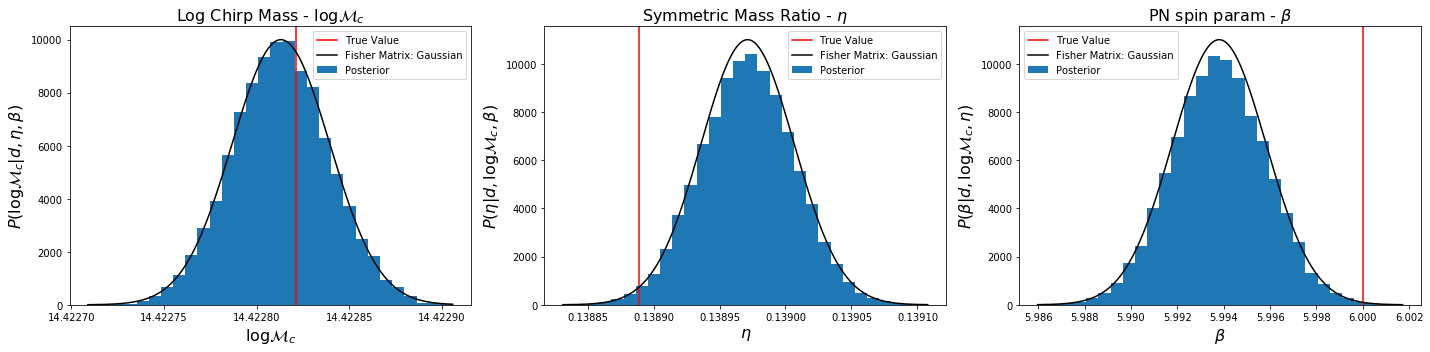

In [11]:
# Check Fisher Matrix Result
%matplotlib inline

mean_log_Mchirp_1 = np.mean(logM_chirp_1_samps)
mean_eta_1 = np.mean(eta_1_samps)
mean_beta_1 = np.mean(beta_1_samps)

sd_log_Mchirp_1 = np.sqrt(np.diag(Cov_Matrix)[0])
sd_eta_1 = np.sqrt(np.diag(Cov_Matrix)[1])
sd_beta_1 = np.sqrt(np.diag(Cov_Matrix)[2])

logM_chirp_array = np.arange(min(logM_chirp_1_samps),max(logM_chirp_1_samps),sd_log_Mchirp_1/100)
eta_array = np.arange(min(eta_1_samps),max(eta_1_samps),sd_eta_1/100)
beta_array = np.arange(min(beta_1_samps),max(beta_1_samps),sd_beta_1/100)

llike_M_chirp = 10000*np.exp(-0.5*(logM_chirp_array - mean_log_Mchirp_1)**2 / (sd_log_Mchirp_1**2))
llike_eta = 11000*np.exp(-0.5*(eta_array - mean_eta_1)**2 / (sd_eta_1**2))
llike_beta = 11000*np.exp(-0.5*(beta_array - mean_beta_1)**2 / (sd_beta_1**2))

fig,ax = plt.subplots(1,3,figsize = (20,5))

ax[0].hist(logM_chirp_1_samps,bins = 30,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),c = 'red', label = 'True Value')
ax[0].plot(logM_chirp_array,llike_M_chirp, c = 'black', label = 'Fisher Matrix: Gaussian')
ax[0].set_xlabel(r'$\log \mathcal{M}_{c}$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log \mathcal{M}_{c}|d,\eta,\beta)$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}_{c}$',fontsize = 16)
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()



ax[1].hist(eta_1_samps,bins = 30,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'red', label = 'True Value')
ax[1].plot(eta_array,llike_eta, c = 'black', label = 'Fisher Matrix: Gaussian')
ax[1].set_xlabel(r'$\eta$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta|d,\log \mathcal{M}_{c},\beta)$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta$',fontsize = 16)
ax[1].legend()


ax[2].hist(beta_1_samps,bins = 30,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'red', label = 'True Value')
ax[2].plot(beta_array,llike_beta, c = 'black', label = 'Fisher Matrix: Gaussian')
ax[2].set_xlabel(r'$\beta$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta|d,\log \mathcal{M}_{c},\eta)$',fontsize = 16)
ax[2].set_title(r'PN spin param - $\beta$',fontsize = 16)
ax[2].legend()
plt.tight_layout()

In [12]:
# FM formalism

waveform_errors = (htilde(freq_bin,eps_GR,pars_1) - htilde(freq_bin,eps_AP,pars_1))

deltah = noise_f + waveform_errors

b_vec = [inner_prod(diff_vec[i],deltah,PSD,delta_f) for i in range(0,K)]

biases_pred_total = np.matmul(Cov_Matrix,b_vec)

b_vec_n = [inner_prod(diff_vec[i],noise_f,PSD,delta_f) for i in range(0,K)]
b_vec_waveform_errors = [inner_prod(diff_vec[i],waveform_errors,PSD,delta_f) for i in range(0,K)]



biases_pred_n = np.matmul(Cov_Matrix,b_vec_n)
biases_pred_waveform_errors = np.matmul(Cov_Matrix,b_vec_waveform_errors)

biases_pred_unresolved_total =  biases_pred_waveform_errors  + biases_pred_n 

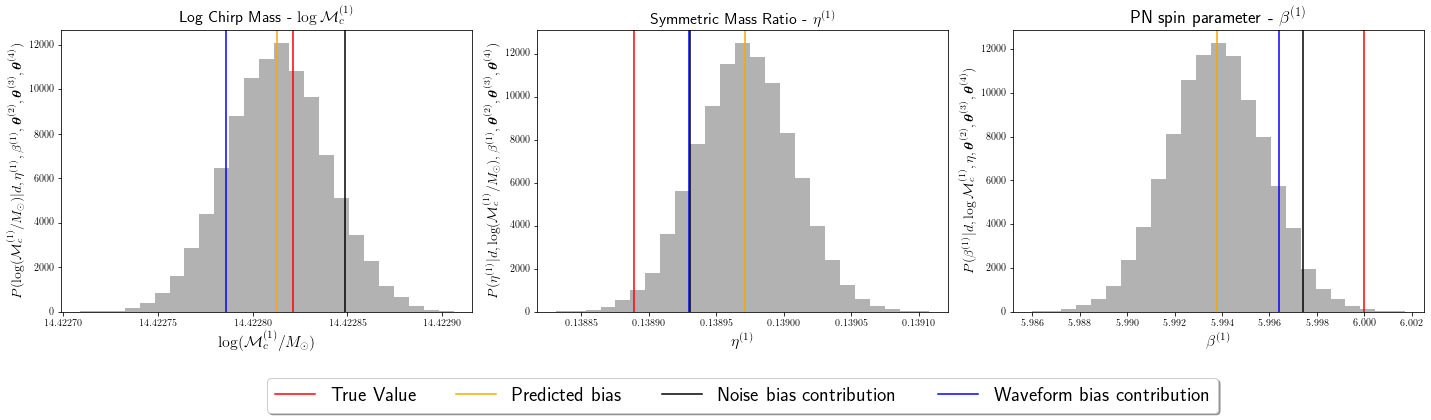

In [13]:
# Results
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


fig,ax = plt.subplots(1,3,figsize = (20,6))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps,bins = 25,color = 'black', histtype = 'stepfilled', alpha = alpha_val)
ax[0].axvline(x = np.log(M_chirp_1),color = 'red',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_total[0], color = 'orange', label = 'Predicted bias')
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_n[0],c = 'black',label = 'Noise bias' )
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_waveform_errors[0],c = 'blue',label = 'Waveform bias' )
ax[0].set_xlabel(r'$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log (\mathcal{M}^{(1)}_{c}/M_{\odot})|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 14)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
# ax[0].show()



ax[1].hist(eta_1_samps,bins = 25, color = 'black', alpha = alpha_val)
ax[1].axvline(x = eta_1,c = 'red', label = 'True Value')
ax[1].axvline(x = eta_1 + biases_pred_unresolved_total[1], color = 'orange', label = 'Predicted bias')
ax[1].axvline(x = eta_1 + biases_pred_n[1],c = 'black',label = 'Noise bias contribution' )
ax[1].axvline(x = eta_1 + biases_pred_waveform_errors[1],c = 'blue',label = 'Waveform bias contribution' )
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log (\mathcal{M}^{(1)}_{c}/M_{\odot}),\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 14)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
# ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps,bins = 25, color = 'black', histtype = 'stepfilled', alpha = alpha_val)
ax[2].axvline(x = beta_1,c = 'red', label = 'True Value')
ax[2].axvline(x = beta_1 + biases_pred_unresolved_total[2],c = 'orange',label = 'Predicted bias' )
ax[2].axvline(x = beta_1 + biases_pred_n[2],c = 'black',label = 'Noise bias' )
ax[2].axvline(x = beta_1 + biases_pred_waveform_errors[2],c = 'blue',label = 'Waveform bias' )
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 14)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 18)

plt.tight_layout()

box = ax[1].get_position()
ax[1].legend(fontsize = 20, loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5)

fig.subplots_adjust(bottom=0.27)

In [ ]:

import corner
samples = np.column_stack([logM_chirp_1_samps,eta_1_samps,beta_1_samps])

figure = corner.corner(samples,bins = 30, color = 'blue',plot_datapoints=False,smooth1d=True,
                       labels=[r"$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$", r"$\eta^{(1)}$", r"$\beta^{(1)}$"],
                       label_kwargs = {"Fontsize":12},set_xlabel = {'fontsize': 20},
                       show_titles=True, title_fmt='.7f',title_kwargs={"fontsize": 9},smooth = True)

axes = np.array(figure.axes).reshape((K,K))
true_vals = [np.log(M_chirp_1),eta_1,beta_1]
for i in range(K):
    ax = axes[i, i]
    ax.axvline(true_vals[i], color="purple",linestyle = "--",label = 'True Values')
    ax.axvline(true_vals[i] + biases_pred_unresolved_total[i] , color="red",label = 'Predicted Bias')
    
for yi in range(K):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axhline(true_vals[yi], color="purple",linestyle = "--")
        ax.axvline(true_vals[xi],color= "purple",linestyle = "--")
        ax.axvline(true_vals[xi] + biases_pred_unresolved_total[xi] , color="red")
        ax.axhline(true_vals[yi] + biases_pred_unresolved_total[yi] , color="red")
        ax.plot(true_vals[xi], true_vals[yi], color = "purple",marker='s')
        ax.plot(true_vals[xi] + biases_pred_unresolved_total[xi] , true_vals[yi] + biases_pred_unresolved_total[yi],
                color="red",marker='s')
        
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=8)
    
plt.legend(bbox_to_anchor=(1, 3),fontsize = 30)